# Install Libraries

In [1]:
!pip install -q -r requirements.txt

In [2]:
!pip install tensorflow

# Import Libraries

In [3]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVR
from sklearn.cluster import KMeans
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences

import mediapipe as mp
import joblib

# Load Datasets

In [4]:
BASE_DIR = r"C:\Users\asus\Documents\2025-Datathon\Model_1"  # change if needed

CSV_PATH = os.path.join(BASE_DIR, "pose_metadata.csv")
CSV_2_PATH = os.path.join(BASE_DIR, "labeled_scored_data.csv")
INDOOR_DIR = os.path.join(BASE_DIR, "Trong nhà - Indoor")
OUTDOOR_DIR = os.path.join(BASE_DIR, "Ngoài trời - Outdoor")

In [5]:
df_pose = pd.read_csv(CSV_PATH)
df_pose.head()

,video_id,video_path,file_name,environment,band,view,duration,fps,resolution,aspect_ratio,file_size_mb,noise_level,pose_path,num_frames_pose,pose_dim
0,1,Public Test_\Ngoài trời - Outdoor\Band 1-2\Bac...,Backside-8897-2.mov,Ngoài trời - Outdoor,band_1-2,backview,7.433333,30.0,"(720, 1280)",0.56,9.32,1001.469901,dataset_pose\Ngoài trời - Outdoor\band_1_2\1.npy,223,"(223, 33, 4)"
1,2,Public Test_\Ngoài trời - Outdoor\Band 1-2\Bac...,Backside-8900-11.mov,Ngoài trời - Outdoor,band_1-2,backview,7.100000,30.0,"(720, 1280)",0.56,9.38,884.584861,dataset_pose\Ngoài trời - Outdoor\band_1_2\2.npy,213,"(213, 33, 4)"
2,3,Public Test_\Ngoài trời - Outdoor\Band 1-2\Sid...,Side-6088-2.mov,Ngoài trời - Outdoor,band_1-2,side,6.333333,30.0,"(720, 1280)",0.56,7.08,1113.882873,dataset_pose\Ngoài trời - Outdoor\band_1_2\3.npy,190,"(190, 33, 4)"
3,4,Public Test_\Ngoài trời - Outdoor\Band 1-2\Sid...,Side-6089-1.mov,Ngoài trời - Outdoor,band_1-2,side,7.466667,30.0,"(720, 1280)",0.56,10.25,1877.845329,dataset_pose\Ngoài trời - Outdoor\band_1_2\4.npy,224,"(224, 33, 4)"
4,5,Public Test_\Ngoài trời - Outdoor\Band 2-4\Bac...,Backside-8900-8.mov,Ngoài trời - Outdoor,band_2-4,backview,7.733333,30.0,"(720, 1280)",0.56,10.16,889.470322,dataset_pose\Ngoài trời - Outdoor\band_2_4\5.npy,232,"(232, 33, 4)"


In [6]:
df_label = pd.read_csv(CSV_2_PATH)
df_label.head()

,video_id,l_elbow_angle_smooth,l_knee_angle_smooth,r_knee_angle_smooth,arm_score,stability_score,total_quality_score,label
0,1,42.079882,5.994746,6.800403,31.786835,69.043093,46.689338,0
1,2,8.996262,18.216000,15.768404,4.693121,0.767377,3.122823,0
2,3,113.205312,5.991895,4.267209,90.034758,77.214701,84.906735,1
3,4,93.216133,8.536985,2.467092,73.664690,74.814261,74.124518,1
4,5,19.259794,7.786089,8.552580,13.098405,57.625214,30.909128,0


In [7]:
print(df_pose["video_id"].is_unique)
print(df_label["video_id"].is_unique)

True
True


# Join Pose and Label datasets

In [8]:
df = df_pose.merge(
    df_label,
    on="video_id",
    how="inner"   # only keep videos that have labels
)

In [9]:
df.head()

,video_id,video_path,file_name,environment,band,view,duration,fps,resolution,aspect_ratio,...,pose_path,num_frames_pose,pose_dim,l_elbow_angle_smooth,l_knee_angle_smooth,r_knee_angle_smooth,arm_score,stability_score,total_quality_score,label
0,1,Public Test_\Ngoài trời - Outdoor\Band 1-2\Bac...,Backside-8897-2.mov,Ngoài trời - Outdoor,band_1-2,backview,7.433333,30.0,"(720, 1280)",0.56,...,dataset_pose\Ngoài trời - Outdoor\band_1_2\1.npy,223,"(223, 33, 4)",42.079882,5.994746,6.800403,31.786835,69.043093,46.689338,0
1,2,Public Test_\Ngoài trời - Outdoor\Band 1-2\Bac...,Backside-8900-11.mov,Ngoài trời - Outdoor,band_1-2,backview,7.100000,30.0,"(720, 1280)",0.56,...,dataset_pose\Ngoài trời - Outdoor\band_1_2\2.npy,213,"(213, 33, 4)",8.996262,18.216000,15.768404,4.693121,0.767377,3.122823,0
2,3,Public Test_\Ngoài trời - Outdoor\Band 1-2\Sid...,Side-6088-2.mov,Ngoài trời - Outdoor,band_1-2,side,6.333333,30.0,"(720, 1280)",0.56,...,dataset_pose\Ngoài trời - Outdoor\band_1_2\3.npy,190,"(190, 33, 4)",113.205312,5.991895,4.267209,90.034758,77.214701,84.906735,1
3,4,Public Test_\Ngoài trời - Outdoor\Band 1-2\Sid...,Side-6089-1.mov,Ngoài trời - Outdoor,band_1-2,side,7.466667,30.0,"(720, 1280)",0.56,...,dataset_pose\Ngoài trời - Outdoor\band_1_2\4.npy,224,"(224, 33, 4)",93.216133,8.536985,2.467092,73.664690,74.814261,74.124518,1
4,5,Public Test_\Ngoài trời - Outdoor\Band 2-4\Bac...,Backside-8900-8.mov,Ngoài trời - Outdoor,band_2-4,backview,7.733333,30.0,"(720, 1280)",0.56,...,dataset_pose\Ngoài trời - Outdoor\band_2_4\5.npy,232,"(232, 33, 4)",19.259794,7.786089,8.552580,13.098405,57.625214,30.909128,0


In [10]:
print(df.isnull().sum()[["label", "total_quality_score"]])

label                  0
total_quality_score    0
dtype: int64


In [11]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df["quality_enc"] = le.fit_transform(df["label"])

print(le.classes_)  # e.g. ['bad', 'good']

[0 1]


# Load Pose Data from pose_path

In [12]:
DATASET_ROOT = r"C:\Users\asus\Documents\2025-Datathon\Model_1"

In [13]:
X = []
y_class = df["quality_enc"].values
y_score = df["total_quality_score"].values
groups = df["video_id"].values

for path in df["pose_path"]:
    landmarks = np.load(path)  # (T,33,4)
    X.append(landmarks)

print("Loaded pose samples:", len(X))

Loaded pose samples: 50


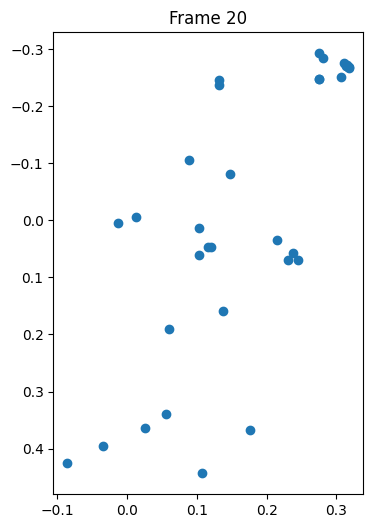

In [14]:
def plot_pose_frame(landmarks, frame=0):
    plt.figure(figsize=(4,6))
    plt.scatter(
        landmarks[frame,:,0],
        landmarks[frame,:,1]
    )
    plt.gca().invert_yaxis()
    plt.title(f"Frame {frame}")
    plt.show()

plot_pose_frame(X[0], frame=20)

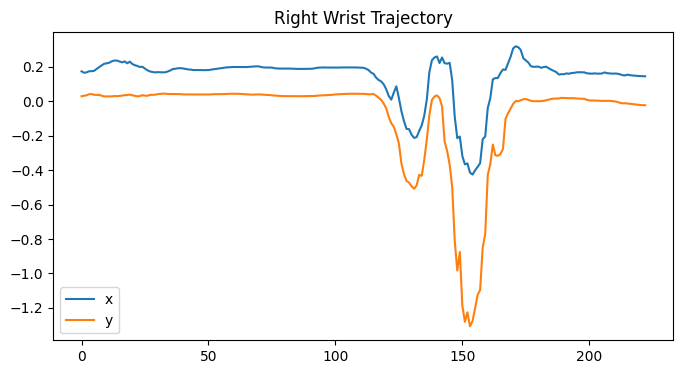

In [15]:
RIGHT_WRIST = 16

plt.figure(figsize=(8,4))
plt.plot(X[0][:,RIGHT_WRIST,0], label="x")
plt.plot(X[0][:,RIGHT_WRIST,1], label="y")
plt.title("Right Wrist Trajectory")
plt.legend()
plt.show()

In [16]:
MAX_FRAMES = 240

X_pad = pad_sequences(
    X,
    maxlen=MAX_FRAMES,
    padding="post",
    truncating="post",
    dtype="float32"
)

X_seq = X_pad.reshape(len(X_pad), MAX_FRAMES, -1)

print(X_seq.shape)

(50, 240, 132)


# Train/Test Split

In [17]:
gss = GroupShuffleSplit(test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(X_seq, y_class, groups))

X_train, X_test = X_seq[train_idx], X_seq[test_idx]
y_train, y_test = y_class[train_idx], y_class[test_idx]

y_score_train, y_score_test = y_score[train_idx], y_score[test_idx]

# Random Forest (Classification)

In [18]:
def aggregate_features(seq):
    mean = seq.mean(axis=0)
    std = seq.std(axis=0)
    return np.concatenate([mean, std])

X_rf = np.array([aggregate_features(x) for x in X_seq])

X_train_rf, X_test_rf = X_rf[train_idx], X_rf[test_idx]

In [19]:
scaler = StandardScaler()
X_train_rf = scaler.fit_transform(X_train_rf)
X_test_rf = scaler.transform(X_test_rf)

In [20]:
print("train features shape:", X_train_rf.shape)
print("test features shape:", X_test_rf.shape)

train features shape: (40, 264)
test features shape: (10, 264)


In [21]:
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=15,
    class_weight="balanced",
    random_state=42
)

rf.fit(X_train_rf, y_train)
y_pred = rf.predict(X_test_rf)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.86      0.92         7
           1       0.75      1.00      0.86         3

    accuracy                           0.90        10
   macro avg       0.88      0.93      0.89        10
weighted avg       0.93      0.90      0.90        10



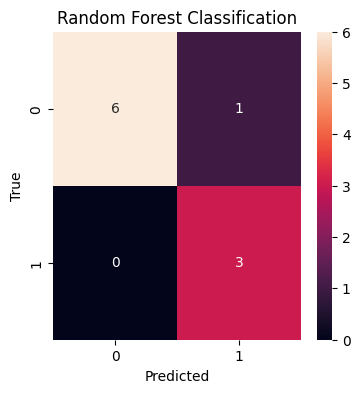

In [22]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(4,4))
sns.heatmap(
    cm, annot=True, fmt="d",
    xticklabels=le.classes_,
    yticklabels=le.classes_
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Random Forest Classification")
plt.show()

# Performance Score Regression (XGBoost)

In [23]:
from xgboost import XGBRegressor

xgb = XGBRegressor(
    n_estimators=500,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb.fit(X_train_rf, y_score_train)
pred_xgb = xgb.predict(X_test_rf)

print("XGB MAE:", mean_absolute_error(y_score_test, pred_xgb))
#print("XGB RMSE:", mean_squared_error(y_score_test, pred_xgb, squared=False))
print("XGB R2:", r2_score(y_score_test, pred_xgb))

XGB MAE: 9.781288969597915
XGB R2: 0.7907546340786957


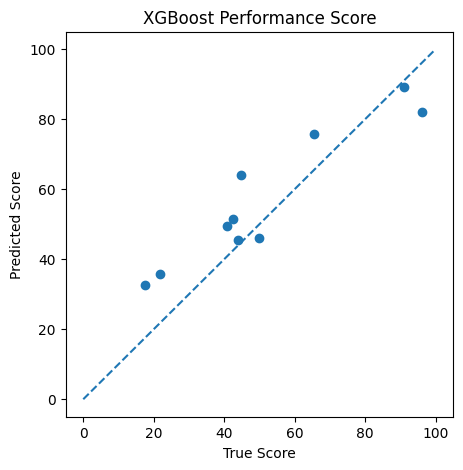

In [24]:
plt.figure(figsize=(5,5))
plt.scatter(y_score_test, pred_xgb)
plt.plot([0,100],[0,100],"--")
plt.xlabel("True Score")
plt.ylabel("Predicted Score")
plt.title("XGBoost Performance Score")
plt.show()

# Testing

In [25]:
try:
    pose_detector
except NameError:
    mp_pose = mp.solutions.pose
    pose_detector = mp_pose.Pose(static_image_mode=False, min_detection_confidence=0.5, min_tracking_confidence=0.5)

try:
    audio_classifier
except NameError:
    class DummyAudioClassifier:
        def classify(self, *args, **kwargs):
            return []
    audio_classifier = DummyAudioClassifier()

try:
    pad_sequences
except NameError:
    from tensorflow.keras.preprocessing.sequence import pad_sequences

def predict_video(video_path):
    cap = cv2.VideoCapture(video_path)
    frames_data = []
    fps = cap.get(cv2.CAP_PROP_FPS) or 30.0

    MAX_FRAMES = globals().get('MAX_FRAMES', 240)

    frame_count = 0
    while cap.isOpened() and len(frames_data) < MAX_FRAMES:
        ret, frame = cap.read()
        if not ret:
            break

        frame_count += 1

        # Convert OpenCV BGR to RGB (MediaPipe solutions API expects RGB)
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Use the solutions API detector (pose_detector) which is compatible and already in the notebook
        result = pose_detector.process(rgb_frame)

        if result and getattr(result, 'pose_landmarks', None):
            lm = [[p.x, p.y, p.z, p.visibility] for p in result.pose_landmarks.landmark]
            frames_data.append(lm)

    cap.release()

    if not frames_data:
        return "No Pose Detected", 0.0

    frames_array = pad_sequences(
        [np.array(frames_data)],
        maxlen=MAX_FRAMES,
        padding="post",
        truncating="post",
        dtype="float32"
    )

    frames_reshaped = frames_array.reshape(1, MAX_FRAMES, -1)

    # 1. Get your sequence from the video
    sequence = pad_sequences([np.array(frames_data)], maxlen=240, padding="post", truncating="post", dtype="float32") 

    # 2. Aggregate to match the 264 train features
    features_264 = aggregate_features(sequence[0]) 

    # 3. Reshape for the model (1 sample, 264 features)
    features_reshaped = features_264.reshape(1, -1)

    # 4. Scale using the SAME scaler fit on training data
    features_scaled = scaler.transform(features_reshaped)

    # 5. Predict
    score = xgb.predict(features_scaled)
    quality = rf.predict(features_scaled)

    label = "Good Swing" if quality[0] > 0.5 else "Bad Swing"
    return label, float(score[0])


In [26]:
video_path = r"sample_video\Backside-8900-11.mov"  
label, score = predict_video(video_path)
print(f"Predicted Label: {label}, Predicted Score: {score}")

Predicted Label: Bad Swing, Predicted Score: 60.87017822265625


## Clustering Model for Swing Type with CaddieSet Dataset

In [27]:
df_caddie = pd.read_csv('CaddieSet_Preprocessed_Numeric.csv')

print("Number of Rows and Columns:", df_caddie.shape)
display(df_caddie.head())
print(df_caddie.columns.tolist())

Number of Rows and Columns: (1757, 91)


,Distance,Carry,LrDistanceOut,DirectionAngle,SpinBack,SpinSide,SpinAxis,BallSpeed,GolferId,0-LOWER-ANGLE,...,Hip_Sway_Std,Spine_Angle_Range,Shoulder_Rotation_Range,Head_Movement_Range,Head_Movement_Std,Weight_Shift_Impact,Hip_Hanging_Back_Max,Shoulder_Hanging_Back_Max,Left_Arm_Consistency,Injury_Risk_Score
0,241.0,221.9,0.0,3.9,1705.0,-331.0,-10.986450,63.0,4.0,158.782,...,0.275404,12.358,30.326,0.57,0.231812,92.800,0.24,0.42,21.473029,0.157896
1,137.7,119.0,0.0,3.0,1868.0,-571.0,-16.997057,45.1,1.0,165.556,...,0.302311,11.816,28.206,0.39,0.145419,94.618,0.00,0.05,27.167803,0.183551
2,204.7,189.3,0.1,-0.6,2162.0,55.0,1.457256,57.9,5.0,163.852,...,0.409872,9.032,27.290,0.25,0.106583,90.770,0.37,0.54,11.599555,0.115764
3,125.3,118.5,0.1,3.3,6442.0,-734.0,-6.500235,45.2,3.0,157.812,...,0.863729,23.324,40.574,0.80,0.358687,96.780,0.25,0.22,31.248681,0.274319
4,214.1,202.9,-32.1,-4.5,2393.0,-462.0,-10.927259,59.0,5.0,171.216,...,0.546373,9.378,22.948,1.24,0.462760,95.820,0.12,0.32,20.270000,0.135791


['Distance', 'Carry', 'LrDistanceOut', 'DirectionAngle', 'SpinBack', 'SpinSide', 'SpinAxis', 'BallSpeed', 'GolferId', '0-LOWER-ANGLE', '0-SHOULDER-ANGLE', '0-SPINE-ANGLE', '0-STANCE-RATIO', '0-UPPER-TILT', '1-HEAD-LOC', '1-HIP-LINE', '1-HIP-ROTATION', '1-HIP-SHIFTED', '1-LEFT-ARM-ANGLE', '1-RIGHT-ARM-ANGLE', '1-SHOULDER-ANGLE', '1-SHOULDER-LOC', '1-SPINE-ANGLE', '2-HEAD-LOC', '2-HIP-ANGLE', '2-HIP-LINE', '2-HIP-ROTATION', '2-HIP-SHIFTED', '2-LEFT-ARM-ANGLE', '2-SHOULDER-ANGLE', '2-SHOULDER-LOC', '2-UPPER-TILT', '3-HEAD-LOC', '3-HIP-ANGLE', '3-HIP-LINE', '3-HIP-ROTATION', '3-HIP-SHIFTED', '3-LEFT-LEG-ANGLE', '3-RIGHT-ARM-ANGLE', '3-RIGHT-DISTANCE', '3-RIGHT-LEG-ANGLE', '3-SHOULDER-ANGLE', '3-SHOULDER-LOC', '4-HEAD-LOC', '4-HIP-ANGLE', '4-HIP-HANGING-BACK', '4-HIP-LINE', '4-HIP-ROTATION', '4-HIP-SHIFTED', '4-RIGHT-ARM-ANGLE', '4-RIGHT-ARMPIT-ANGLE', '4-SHOULDER-HANGING-BACK', '4-SPINE-ANGLE', '5-HEAD-LOC', '5-HIP-HANGING-BACK', '5-HIP-LINE', '5-HIP-SHIFTED', '5-LEFT-ARM-ANGLE', '5-LEFT-L

In [28]:
# Feature Selection based on Biomechanical Principles
target_features = [
    '0-STANCE-RATIO',          # Distinguishes narrow chip vs. wide drive [cite: 60, 172-181]
    'Shoulder_Rotation_Range', # Distinguishes short unit-movements vs. full turns 
    'X_Factor_Top',            # Measures the torque/power generated in the backswing 
    '0-SPINE-ANGLE',           # Captures address tilt (pronounced vs. stacked) 
    '1-LEFT-ARM-ANGLE',     # Captures arm extension and swing arc width
    'Hip_Sway_Range'           # Tracks the lateral weight shift described in your notes 
]
    
X = df_caddie[target_features]

In [29]:
# Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [30]:
# Build the K-Means Model (k=3 for Drive, Iron, Chip)
kmeans = KMeans(n_clusters=3, init='k-means++', random_state=42)
df_caddie['cluster_id'] = kmeans.fit_predict(X_scaled)

print("Cluster IDs : \n", df_caddie['cluster_id'].unique())

Cluster IDs : 
 [0 1 2]


In [31]:
# Mapping Cluster ID to Swing Names
# Since K-Means assigns IDs (0, 1, 2) randomly, use the average 'Distance' per cluster to identify them.
# Highest Distance = Drive | Mid Distance = Iron | Lowest Distance = Chip
cluster_averages = df_caddie.groupby('cluster_id')['Distance'].mean().sort_values(ascending=False)

mapping = {
    cluster_averages.index[0]: 'Drive',
    cluster_averages.index[1]: 'Iron',
    cluster_averages.index[2]: 'Chip'
}

df_caddie['swing_type'] = df_caddie['cluster_id'].map(mapping)

print("Clustering Summary")
for cid, name in mapping.items():
    avg_dist = df_caddie[df_caddie['cluster_id'] == cid]['Distance'].mean()
    print(f"Cluster {cid} identified as: {name} (Avg Distance: {avg_dist:.1f}m)")

#Save the model

joblib.dump(kmeans, 'clustering_model\\swing_kmeans_model.pkl')
joblib.dump(scaler, 'clustering_model\\swing_scaler.pkl')
joblib.dump(mapping, 'clustering_model\\swing_mapping.pkl')
joblib.dump(target_features, 'clustering_model\\swing_features.pkl')

Clustering Summary
Cluster 0 identified as: Drive (Avg Distance: 188.0m)
Cluster 1 identified as: Iron (Avg Distance: 146.4m)
Cluster 2 identified as: Chip (Avg Distance: 124.1m)


['clustering_model\\swing_features.pkl']

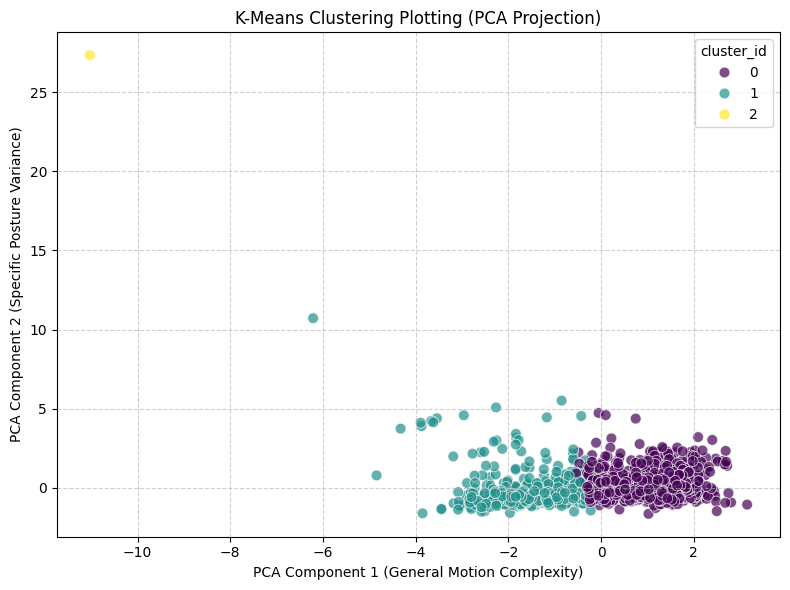

<Figure size 640x480 with 0 Axes>

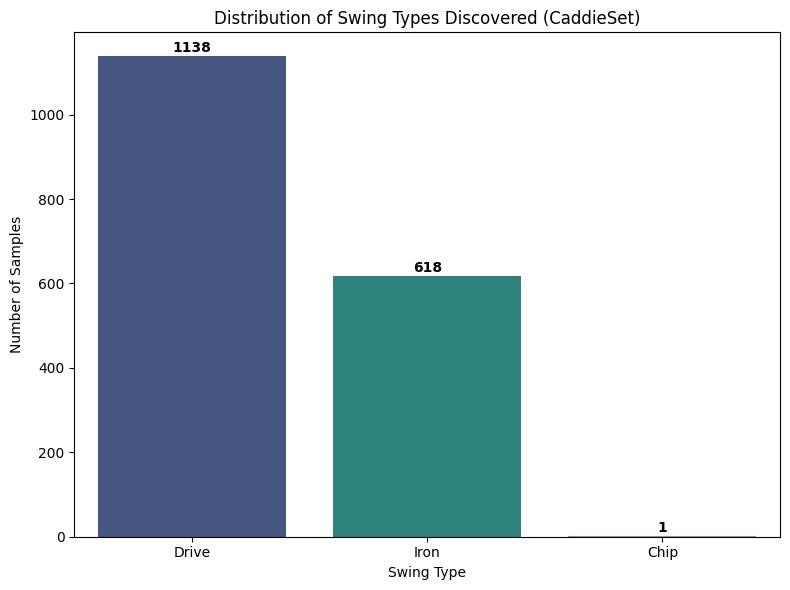

In [32]:
# PCA for Visualization
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
df_caddie['PCA1'] = X_pca[:, 0]
df_caddie['PCA2'] = X_pca[:, 1]

#Scatter Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_caddie, x='PCA1', y='PCA2', hue='cluster_id', palette='viridis', s=60, alpha=0.7)
plt.title('K-Means Clustering Plotting (PCA Projection)')
plt.xlabel('PCA Component 1 (General Motion Complexity)')
plt.ylabel('PCA Component 2 (Specific Posture Variance)')
plt.legend(title='cluster_id')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
plt.savefig('swing_clustering_scatter.png')


# Bar Chart of Swing Types Distribution
counts_df = df_caddie['swing_type'].value_counts().reset_index()
counts_df.columns = ['Swing Type', 'Count']
counts_df = counts_df.sort_values(by='Count', ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(data=counts_df, x='Swing Type', y='Count', hue='Swing Type', palette='viridis', dodge=False)
plt.title('Distribution of Swing Types Discovered (CaddieSet)')
plt.xlabel('Swing Type')
plt.ylabel('Number of Samples')

for i, count in enumerate(counts_df['Count']):
    plt.text(i, count + 10, str(count), ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('swing_type_distribution.png')

# Model Prediction Test

In [33]:
def calculate_angle(a, b, c):
    a, b, c = np.array(a), np.array(b), np.array(c)
    res = np.abs(np.degrees(np.arctan2(c[1]-b[1], c[0]-b[0]) - np.arctan2(a[1]-b[1], a[0]-b[0])))
    return 360-res if res > 180 else res

def analyze_video(video_path):
    # Load requirements
    model = joblib.load('clustering_model\\swing_kmeans_model.pkl')
    scaler = joblib.load('clustering_model\\swing_scaler.pkl')
    mapping = joblib.load('clustering_model\\swing_mapping.pkl')
    features = joblib.load('clustering_model\\swing_features.pkl')

    cap = cv2.VideoCapture(video_path)
    mp_pose = mp.solutions.pose
    pose = mp_pose.Pose()
    
    all_lms, s_angles, h_angles, arm_angles, h_x = [], [], [], [], []

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret: break
        res = pose.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        if res.pose_landmarks:
            lm = res.pose_landmarks.landmark
            all_lms.append(lm)
            
            # 1. Shoulder/Hip Tilts (for Rotation & X-Factor)
            s_angles.append(np.degrees(np.arctan2(lm[12].y - lm[11].y, lm[12].x - lm[11].x)))
            h_angles.append(np.degrees(np.arctan2(lm[24].y - lm[23].y, lm[24].x - lm[23].x)))
            
            # 2. Arm Angle (for Max Arm)
            arm_angles.append(calculate_angle([lm[11].x, lm[11].y], [lm[13].x, lm[13].y], [lm[15].x, lm[15].y]))
            
            # 3. Hip X (for Sway)
            h_x.append((lm[23].x + lm[24].x) / 2)
            
    cap.release()

    if all_lms:
        addr = all_lms[0]
        # Calculate Final Vector
        stance = np.linalg.norm(np.array([addr[27].x, addr[27].y]) - np.array([addr[28].x, addr[28].y])) / \
                 (np.linalg.norm(np.array([addr[11].x, addr[11].y]) - np.array([addr[12].x, addr[12].y])) + 1e-6)
        rot_range = max(s_angles) - min(s_angles)
        top_idx = np.argmax(np.abs(s_angles))
        x_factor = np.abs(s_angles[top_idx] - h_angles[top_idx])
        spine = calculate_angle([addr[11].x, addr[11].y], [addr[23].x, addr[23].y], [addr[23].x, addr[23].y - 0.5])
        max_arm = max(arm_angles)
        sway = (max(h_x) - min(h_x)) * 100

        # Vector Assembly in EXACT order
        final_v = [stance, rot_range, x_factor, spine, max_arm, sway]
        final_df = pd.DataFrame([final_v], columns=features)
        
        # Prediction
        pred = mapping[model.predict(scaler.transform(final_df))[0]]
        print(f"\nSwing Type Detected: {pred}")
        return pred, final_v

In [34]:
# Run with  specific file path
analyze_video(r"sample_video\Backside-8900-11.mov")


Swing Type Detected: Drive


('Drive',
 [10.285747650961147,
  336.64967659763454,
  350.2218891420731,
  50.71882097002209,
  177.60683370827743,
  5.042494833469391])

In [35]:
analyze_video(r"sample_video\Side-6020-7.mov")


Swing Type Detected: Iron


('Iron',
 [1.219805470550323,
  359.9846037310102,
  357.9444822157825,
  22.473245358853763,
  179.9042378201792,
  11.975716054439545])